In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from tqdm import tqdm
from scipy.stats import multivariate_normal

$$
\mu_c, \pi_c \text{ y } \sum_c \text{ son fijos, y se calcula la probabilidad de que pertenezca a un cluster } \pi \text{. Así se hace con todos.}
$$

In [2]:
def E_step(largos, anchos, mu, sigma, pi, K):
    N = len(largos)
    responsibilities = np.zeros((N, K))

    for i in range(N):
        for j in range(K):
            responsibilities[i, j] = pi[j] * multivariate_normal.pdf([largos[i], anchos[i]], mu[j], sigma[j])

        if np.sum(responsibilities[i, :]) != 0:
            responsibilities[i, :] /= np.sum(responsibilities[i, :])
        else:
            responsibilities[i, :] = 1/K

    return responsibilities

$$

\gamma Z_{n,k} = \frac{\pi_k N\left(X_n \mid \mu_k, \omega_k\right)}{\sum_{j} \pi_j N\left(X_n \mid \mu_j, \omega_j\right)}

\\\\\\

\gamma Z_{1,1} = \frac{\pi^0_1 N\left(X_1 \mid \mu^0_1, \omega^0_1\right)}{\pi^0_1 N\left(X_1 \mid \mu^0_1, \omega^0_1\right) + \pi^1_1 N\left(X_1 \mid \mu^1_1, \omega^0_1\right)}

$$




$$
\mu_c, \pi_c, \sum_c $$  son fijos, esto mira la prob de que pertenezca a un cluster $$\pi$$, lo hago con todos


In [3]:

def M_step(largos, anchos, mu, sigma, pi, K, responsibilities):
    new_mu = np.zeros((K, 2))
    new_sigma = np.zeros((K, 2, 2))
    new_pi = np.zeros(K)
    for k in range(K):
        new_mu[k] = np.sum(responsibilities[:, k][:, np.newaxis] * np.array([largos, anchos]).T, axis=0) / np.sum(responsibilities[:, k])
        new_sigma[k] = np.zeros((2, 2))
        for n in range(len(largos)):
            new_sigma[k] += responsibilities[n, k] * np.outer(np.array([largos[n], anchos[n]]) - new_mu[k], np.array([largos[n], anchos[n]]) - new_mu[k])
        new_sigma[k] /= np.sum(responsibilities[:, k])
        new_pi[k] = np.sum(responsibilities[:, k]) / len(largos)
    
    return new_mu, new_sigma, new_pi

$$
\mu_k = \frac{1}{N} \sum_{n=1}^{N} \gamma(Z_{n,k}) X_n  
\quad (\text{donde } N \text{ es la cantidad de clases})
\\

c_{1,1} = \gamma(Z_{n,k}) \cdot \text{primer valor de la clase} + \gamma(Z_{n,k}) \cdot \text{segundo valor de la clase} + \ldots
\\

N_k = \sum_{n=1}^{N} \gamma(Z_{n,k})
\\


\omega_k = \frac{1}{N} \sum_{n=1}^{N} \gamma(Z_{n,1}) (X_n - \mu^1_1)^2
\\

\pi^1_1 = \frac{\mu_k}{Z_{n,k}}

$$



In [4]:
def EM_algorithm(largos, anchos, K, max_iters=1000, tol=1e-100):
    N = len(largos)
    mu = np.array([(np.random.rand(), np.random.rand()) for _ in range(K)])
    sigma = np.array([np.eye(2) for _ in range(K)])
    pi = np.ones(K) / K
    log_likelihoods = []
    all_params = []

    for iteracion in tqdm(range(max_iters)):
        # Paso E (Expectation)
        responsibilities = E_step(largos, anchos, mu, sigma, pi, K)

        # Paso M (Maximization)
        mu, sigma, pi = M_step(largos, anchos, mu, sigma, pi, K, responsibilities)
        all_params.append((mu, sigma, pi))

        # Calcular log-verosimilitud para verificar convergencia
        log_likelihood = 0
        for i in range(N):
            log_likelihood += np.log(np.sum([pi[k] * multivariate_normal.pdf([largos[i], anchos[i]], mu[k], sigma[k]) for k in range(K)]))

        log_likelihoods.append(log_likelihood)

        # Verificar convergencia
        if iteracion > 0 and abs(log_likelihood - log_likelihoods[iteracion - 1]) < tol:
            break

    return all_params, log_likelihoods

In [5]:
def plot_convergence(log_likelihoods):
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.plot(log_likelihoods, marker='o', linestyle='-')
    ax.set_xlabel('Iteración')
    ax.set_ylabel('Log-verosimilitud')
    ax.set_title('Convergencia de Log-verosimilitud')
    plt.show()


In [6]:
def plot_histograms(largos, anchos):
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.hist(largos, bins=30, alpha=0.5, color='blue', label='Largo')
    ax.hist(anchos, bins=30, alpha=0.5, color='orange', label='Ancho')
    ax.set_title('Histogramas de Largo y Ancho')
    ax.legend()
    plt.show()


In [7]:
def plot_data_and_clusters_iteration(largos, anchos, mu, sigma, pi, K, iteration):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.scatter(largos, anchos, alpha=0.5, label='Datos', color='grey')

    for k in range(K):
        ax.scatter(mu[k, 0], mu[k, 1], marker='x', s=100, label=f'Centroide Cluster {k + 1}')

        cov_matrix = sigma[k]
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
        width, height = 2 * np.sqrt(eigenvalues)

        for i in range(1, 4):
            color = f'C{k}'
            ellipse = Ellipse(mu[k], i * width, i * height, angle=angle, fill=False, color=color, linestyle='dashed', alpha=0.5)
            ax.add_patch(ellipse)

    ax.set_title(f'Datos y Componentes de Clusters con Elipses (Iteración {iteration})')
    ax.legend()
    plt.show()

  4%|▎         | 37/1000 [00:05<02:29,  6.42it/s]


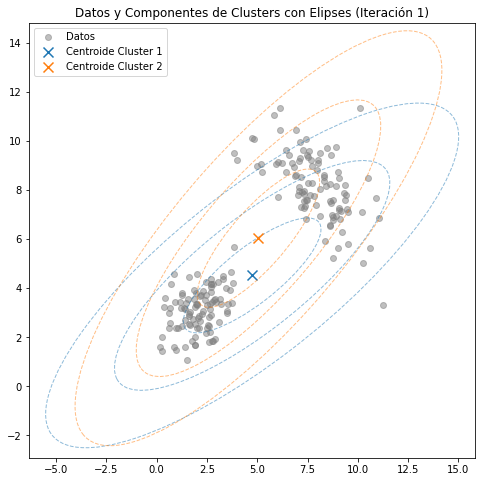

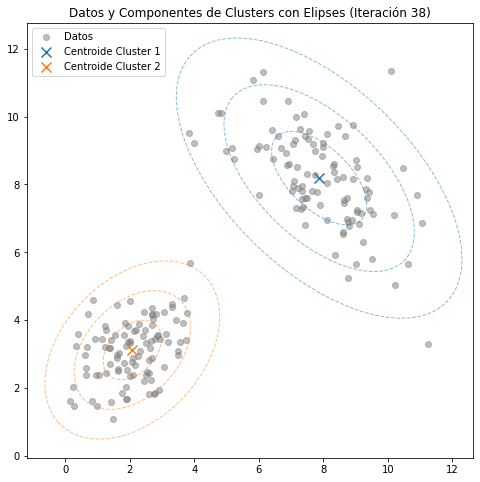

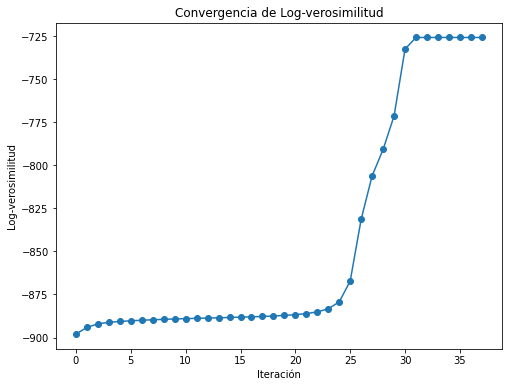

In [8]:
# Generar datos de ejemplo
np.random.seed(42)
data1 = np.random.multivariate_normal([2, 3], [[1, 0.5], [0.5, 1]], size=100)
data2 = np.random.multivariate_normal([8, 8], [[2, -1], [-1, 2]], size=100)
data = np.vstack([data1, data2])

# Extraer dimensiones de largo y ancho
largos = data[:, 0]
anchos = data[:, 1]

# Número de componentes en el modelo de mezcla gaussiana
K = 2 #cantidad de cluster

# Llamar a la función EM_algorithm
all_params, log_likelihoods = EM_algorithm(largos, anchos, K)

# Usar las funciones para plotear

# Plotear la primera iteración
plot_data_and_clusters_iteration(largos, anchos, all_params[0][0], all_params[0][1], all_params[0][2], K, iteration=1)

# Plotear la última iteración
plot_data_and_clusters_iteration(largos, anchos, all_params[-1][0], all_params[-1][1], all_params[-1][2], K, iteration=len(all_params))

# Plotear la convergencia
plot_convergence(log_likelihoods)


$$
\text{los valores de } \mu \text{ y } \sum \text{ que me den los pongo en datos}
$$